# Déployez un modèle dans le cloud

Auteur : Eric LAURENT  
Date : Avril 2022  
Pour la société : __Fruits!__

Objectif du projet : 
* 1ere brique dans une application de reconnaissance d'images de fruits
* pré-processing d'images et une réduction de dimension

Dans un contexte BigData :
* utilisation de scripts PySpark
* sur une machine AWS / EC2
* avec un stockage des images sources et du fichier de résultats sous AWS / S3

Ce notebook permet de travailler avec des fichiers : 
* stockés localement (PC ou machine AWS/EC2 type Linux / Ubuntu)
* ou stockés sur le système de fichiers AWS/S3

Jeu de données :
* l'application prend  en compte toutes les images du répertoire __Fruits__ local ou distant (s3).
* afin de limiter les temps de traitements et la puissance de calcul sur machine AWS/EC2, j'ai choisi 3 fruits et 5 images par fruit. (validation de faisabilité)

# Import des librairies 

In [1]:
import findspark
findspark.init()

In [2]:
# Manipulation de tableaux, des données et réalisation de graphiques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Pour traitements SPARK
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, split, pandas_udf, PandasUDFType, col

In [4]:
# Traitement d'image
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import io

In [5]:
import os

In [6]:
# SDK AWS S3
import boto3
    # Pré-requis : 
        # Créer un utilisateur sur AWS/iam et donner les droits d'accès
        # Copier les aws_access_key_id et aws_secret_access_key dans ~/.aws/credentials [default]
        # Renseigner region = eu-west-3 et output = json dans ~/.aws/config [default]

# S3 FUSE fileSystem
import s3fs

In [7]:
# Suppression de warnings Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Création de la session spark

In [8]:
# Utilisation des bonnes versions de fichiers .jars et settings
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.12.201,org.apache.hadoop:hadoop-aws:3.3.1 pyspark-shell'

In [9]:
# Lecture des clés d'accès à S3 dans le fichier ~/.aws/credentials
credentials=pd.read_csv("~/.aws/credentials",sep="=")
aws_access_key_id=(credentials['[default]'][0]).lstrip()
aws_secret_access_key=(credentials['[default]'][1]).lstrip()

In [10]:
# Construction de la session Spark
spark=SparkSession.builder \
.appName('reconnaissanceFruits') \
.master('local[*]') \
.config('spark.driver.memory','7G') \
.config('spark.hadoop.fs.s3a.access.key', aws_access_key_id) \
.config('spark.hadoop.fs.s3a.secret.key', aws_secret_access_key) \
.config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') \
.getOrCreate()

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/eric/.ivy2/cache
The jars for the packages stored in: /home/eric/.ivy2/jars
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-017f1ef7-4b4b-4bd1-a644-6ca12458c113;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.12.201 in central
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 313ms :: artifacts dl 13ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.901 from central in [default]
	com.amazonaws#aws-java-sdk-pom;1.12.201 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.1 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	

In [11]:
# Reconnaissance des formats du format de système de fichiers aws/s3
spark.sparkContext.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")

In [12]:
spark

# Création d'un DataFrame d'images 

## Choix : fichiers sources et résultat en local ou sur AWS/S3 ?

In [13]:
choix_local=False # (pour travailler avec fichiers sur la machine locale, mettre la valeur à True)

## Paramètres généraux

In [14]:
# Taille des images 100x100 en 3 canaux RGB
taille_image=(100,100,3)

##  Test Connexion au bucket S3

In [15]:
if not choix_local :
    # Paramètres bucket
    my_bucket='ericlaur73bucket'
    repertoire_images_s3="Projet8/dataSource/Fruits/"
    repertoire_resultat_s3="Projet8/resultat/"

    # Test de connexion S3
    s3 = boto3.client('s3')
    contenu_bucket = s3.list_objects(Bucket=my_bucket, Prefix=repertoire_images_s3)['Contents']
    for objet in contenu_bucket[:10]:
        print(f"{objet['Key']} ... trouvé !")
    print('...')

Projet8/dataSource/Fruits/Apricot/0_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Apricot/200_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Apricot/r_0_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Apricot/r_200_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Apricot/r_320_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Banana/0_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Banana/150_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Banana/323_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Banana/r_100_100.jpg ... trouvé !
Projet8/dataSource/Fruits/Banana/r_250_100.jpg ... trouvé !
...


## A partir de dossiers locaux sur le PC ou la machine AWS/EC2 

In [16]:
if choix_local :
    
    # Savoir si session sur PC ou EC2
    import socket
    hostname=socket.gethostname()

    # Chemin de d'accès aux images (MORPHEUS c'est nom de mon PC)
    if hostname=='MORPHEUS':
        repertoire_images_local="/mnt/DataLinux/Documents/Projet8/dataSource/Fruits/*" # sur PC
    else :
        repertoire_images_local="/home/ubuntu/Documents/Projet8/dataSource/Fruits/*" # sur machine AWS/EC2

    # Remplacer les espaces dans les noms de répertoire par underscore _
    # pour éviter erreur de chargement des images.
    instruction="for file in "+repertoire_images_local+"; do mv \"$file\" `echo $file | tr ' ' '_'`; done > /dev/null 2>&1"
    os.system(instruction)

    # Chargement des images type *.jpg en mode récursif 
    echantillon = spark.read.format("binaryfile").option("pathGlobFilter","*.jpg") \
        .option("recursiveFileLookup", "true").load(repertoire_images_local)

##  A partir des fichiers stockés dans mon bucket AWS/S3

In [17]:
if not choix_local:
    
    # URL d'accès au bucket
    s3_path="s3a://"+my_bucket+'/'+repertoire_images_s3+'*'

    # Chargement des images type *.jpg en mode récursif 
    echantillon = spark.read.format("binaryfile").option("pathGlobFilter","*.jpg") \
        .option("recursiveFileLookup", "true").load(s3_path)

In [18]:
echantillon.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [19]:
echantillon.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://ericlaur73b...|2022-04-23 10:11:32|  4529|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:30|  4513|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4453|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:27|  4414|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4406|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4398|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4356|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:31|  4254|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:32|  4242|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:31|  4212|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|2022-04-23 10:11:29|  3643|[FF D8 FF E0 00 1...|
|s3a:/

In [20]:
# Dimensions
print((echantillon.count(),len(echantillon.columns)))

(15, 4)


# Etiquetage des images

In [21]:
# Chemin d'accès aux images
echantillon.select('path').show(truncate=False)

+----------------------------------------------------------------------+
|path                                                                  |
+----------------------------------------------------------------------+
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Kaki/r_327_100.jpg   |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Kaki/327_100.jpg     |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Apricot/0_100.jpg    |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Apricot/200_100.jpg  |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Apricot/r_0_100.jpg  |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Apricot/r_320_100.jpg|
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Apricot/r_200_100.jpg|
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Kaki/149_100.jpg     |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Kaki/12_100.jpg      |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/Kaki/r_135_100.jpg   |
|s3a://ericlaur73bucket/Projet8/dataSource/Fruits/B

In [22]:
# La position du nom du fruit en fonction du nombre de "/" de la colonne path
position_nomFruit=str(echantillon.select('path').take(1)[0]).count('/')-1

In [23]:
echantillon=echantillon.withColumn('label',lit(split(echantillon['path'],'/').getItem(position_nomFruit)))

In [24]:
echantillon.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)



In [25]:
echantillon.show()

+--------------------+-------------------+------+--------------------+-------+
|                path|   modificationTime|length|             content|  label|
+--------------------+-------------------+------+--------------------+-------+
|s3a://ericlaur73b...|2022-04-23 10:11:32|  4529|[FF D8 FF E0 00 1...|   Kaki|
|s3a://ericlaur73b...|2022-04-23 10:11:30|  4513|[FF D8 FF E0 00 1...|   Kaki|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4453|[FF D8 FF E0 00 1...|Apricot|
|s3a://ericlaur73b...|2022-04-23 10:11:27|  4414|[FF D8 FF E0 00 1...|Apricot|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4406|[FF D8 FF E0 00 1...|Apricot|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4398|[FF D8 FF E0 00 1...|Apricot|
|s3a://ericlaur73b...|2022-04-23 10:11:28|  4356|[FF D8 FF E0 00 1...|Apricot|
|s3a://ericlaur73b...|2022-04-23 10:11:31|  4254|[FF D8 FF E0 00 1...|   Kaki|
|s3a://ericlaur73b...|2022-04-23 10:11:32|  4242|[FF D8 FF E0 00 1...|   Kaki|
|s3a://ericlaur73b...|2022-04-23 10:11:31|  4212|[FF

In [26]:
# Nombre d'images par fruit
echantillon.groupBy('label').count().sort('label').show()

+-------+-----+
|  label|count|
+-------+-----+
|Apricot|    5|
| Banana|    5|
|   Kaki|    5|
+-------+-----+



# Nettoyage du df echantillon d'images

In [27]:
echantillon = echantillon.select('path','label','content')
echantillon.show(5)

+--------------------+-------+--------------------+
|                path|  label|             content|
+--------------------+-------+--------------------+
|s3a://ericlaur73b...|   Kaki|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|   Kaki|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|Apricot|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|Apricot|[FF D8 FF E0 00 1...|
|s3a://ericlaur73b...|Apricot|[FF D8 FF E0 00 1...|
+--------------------+-------+--------------------+
only showing top 5 rows



# Features engineering : extraction de features des images par VGG16

In [28]:
from keras.applications.vgg16 import VGG16, preprocess_input

## Test sur une image

In [29]:
image_test=np.array(echantillon.select('content').take(1))

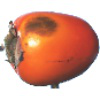

In [30]:
img = Image.open(io.BytesIO(image_test))
img

In [31]:
model_VGG16 = VGG16(include_top=False,input_shape=taille_image) # uniquement extraction des features

In [32]:
arr = img_to_array(img)
arr.shape

(100, 100, 3)

In [33]:
ppi = preprocess_input(arr)
ppi = np.expand_dims(ppi,axis=0)
ppi.shape

(1, 100, 100, 3)

In [34]:
features=model_VGG16.predict(ppi)

In [35]:
features.shape

(1, 3, 3, 512)

In [36]:
features

array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 8.961146 ,  7.2652364,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [28.022755 ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [11.626271 ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]]]], dtype=float32)

In [37]:
features_list=[p.flatten() for p in features] # transforme la matrice en 1 liste/vecteur de valeurs

In [38]:
features_list[0].shape

(4608,)

In [39]:
features_list

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

## Généralisation de l'extraction de features à toutes les images du df echantillon
source : https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [40]:
# Création du modèle VGG16, en s'arrêtant à la couche d'extraction des features
model = VGG16(include_top=False,input_shape=taille_image)

# Diffusion des poids du modèle à tous les noeuds (variable partagée en lecture seule)
bc_model_weights=spark.sparkContext.broadcast(model.get_weights())

In [41]:
def model_fn():
    """
    Returns a VGG16 model with top layer removed and broadcasted pretrained weights.
    """
    model = VGG16(weights=None, include_top=False,input_shape=taille_image)
    model.set_weights(bc_model_weights.value)
    return model

In [42]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content))
    arr = img_to_array(img)
    return preprocess_input(arr)

In [43]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [44]:
from typing import Iterator

@pandas_udf('array<float>')
def featurize_udf(content_series_iter : Iterator[pd.Series]) -> Iterator[pd.Series]:
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
    
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

In [45]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [46]:
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df = echantillon.repartition(16).select(col("path"),col("label"),featurize_udf("content").alias("features"))

In [47]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [48]:
# Dimensions
print((features_df.count(),len(features_df.columns)))

(15, 3)


In [49]:
features_df.sort('label').show()

+--------------------+-------+--------------------+
|                path|  label|            features|
+--------------------+-------+--------------------+
|s3a://ericlaur73b...|Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|Apricot|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...| Banana|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...| Banana|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...| Banana|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...| Banana|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...| Banana|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|   Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|   Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|   Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|   Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://ericlaur73b...|   Kaki|[0.0, 0.0, 0.0, 0...|
+--------------------+-------+--------------------+



# Réduction de dimension (PCA)


In [50]:
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

In [51]:
# Fonction de conversion la liste de valeur numpy en vecteur dense 
# format d'entrée attendu par l'objet StandardScaler, PCA
arrayfloat_to_vector = udf(lambda l: Vectors.dense(l), VectorUDT())

In [52]:
# Modification du type de la colonne features
features_df=features_df.withColumn("features",arrayfloat_to_vector(features_df["features"]))

In [53]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)



In [54]:
# Pré-processing : standardisation des valeurs des vecteurs de caractéristiques
std = StandardScaler(withMean=True, withStd=True, inputCol='features') # retrancher moyenne, diviser par écart-type
std.setOutputCol('features_std')

model_std = std.fit(features_df)
features_df = model_std.transform(features_df)

In [55]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_std: vector (nullable = true)



In [60]:
# Création de l'objet pca
pca = PCA(k=8, inputCol="features_std") # k est le nombre de composantes principales (axes d'inertie)
pca.setOutputCol("pca_features")

PCA_3dc1d8baca21

In [61]:
model_pca = pca.fit(features_df)

In [62]:
# % de Variance expliquée par les axes d'inertie retenus
variance_expliquee=model_pca.explainedVariance
variance_expliquee

DenseVector([0.1807, 0.152, 0.1269, 0.105, 0.085, 0.0804, 0.0769, 0.0523])

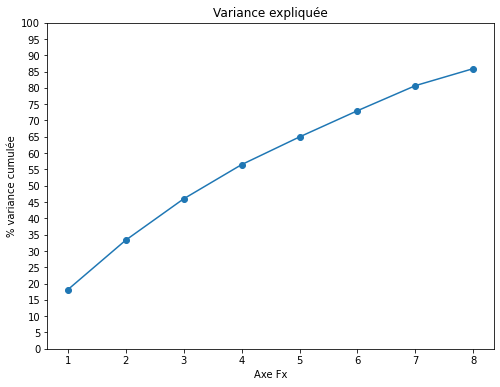

In [63]:
plt.figure(figsize=(8,6))
plt.plot(range(1,len(variance_expliquee)+1),np.cumsum(model_pca.explainedVariance*100), marker='o')
plt.title("Variance expliquée")
plt.xlabel("Axe Fx")
plt.xticks(range(1,len(variance_expliquee)+1))
plt.yticks(range(0,105,5))
plt.ylabel("% variance cumulée")
plt.show()

In [64]:
np.cumsum(model_pca.explainedVariance*100)

array([18.07460454, 33.27415596, 45.9606338 , 56.45837979, 64.96126167,
       72.9997526 , 80.6915526 , 85.91671963])

Avec 8 composantes principales j'explique  86% de l'inertie totale du modèle.

In [65]:
reduction_pca=model_pca.transform(features_df)

In [66]:
reduction_pca.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_std: vector (nullable = true)
 |-- pca_features: vector (nullable = true)



# Sauvegarde des features après réduction (.csv)

In [67]:
# Nettoyage du dataframe
reduction_pca=reduction_pca.drop('features','features_std')

# Transformation du dataframe pyspark --> pandas
matrice_output=reduction_pca.toPandas()

In [68]:
matrice_output

,path,label,pca_features
0,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Kaki,"[11.614026580881616, 2.675252751221351, 1.4252..."
1,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Apricot,"[10.538855470191129, -0.42096060214406555, 1.5..."
2,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Apricot,"[14.432249301530861, 2.022308607044849, 3.1708..."
3,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Kaki,"[11.270779698567166, 2.826404346998833, 1.2510..."
4,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Kaki,"[13.304089843868658, 4.321748270024043, 3.2986..."
5,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Banana,"[-10.895845450304199, -12.76741226412221, 3.27..."
6,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Banana,"[-10.949472055406302, -14.798822458452943, -0...."
7,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Banana,"[-17.287941986937625, 7.565516353834873, -56.8..."
8,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Kaki,"[9.39869151453515, 10.774550552080552, 4.44858..."
9,s3a://ericlaur73bucket/Projet8/dataSource/Frui...,Apricot,"[11.132380594109929, 0.5118068989746906, 2.353..."


In [69]:
# Cas de sauvegarde du résultat sur S3
if not choix_local :
    s3_path_resultat="s3a://"+my_bucket+'/'+repertoire_resultat_s3 
    matrice_output.to_csv(s3_path_resultat+'reconnaissanceFruits_output.csv',index=False)

# Cas de sauvegarde du résultat en local (PC ou machine AWS/EC2)
if choix_local :
    if hostname=="MORPHEUS": 
        #PC
        matrice_output.to_csv('/mnt/DataLinux/Documents/Projet8/Application/reconnaissanceFruits_output.csv', index=False)
    else : 
        #EC2
        matrice_output.to_csv('/home/ubuntu/Documents/Projet8/Application/reconnaissanceFruits_output.csv', index=False) 

In [70]:
# arrêt de la session spark
spark.stop()